<a href="https://colab.research.google.com/github/Harishwar07/Encryptix/blob/main/Task_1_movie_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install googletrans

In [ ]:
pip install langdetect

In [ ]:
pip install pycountry

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
from time import time
import re
import string
import nltk
from googletrans import Translator
from langdetect import detect
import pycountry
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv(r"/content/drive/MyDrive/train_data.txt",sep=':::',names=['Title', 'Genre', 'Description']).reset_index(drop=True)
train.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
test = pd.read_csv(r"/content/drive/MyDrive/test_data.txt",sep=':::',names=['Title', 'Description']).reset_index(drop=True)
test.head()

,Title,Description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


In [ ]:
train.describe(include='object').T

,count,unique,top,freq
Title,54214,54214,Nature's Fury: Storm of the Century (2006),1
Genre,54214,27,drama,13613
Description,54214,54086,Grammy - music award of the American academy ...,12


In [ ]:
train.info()
#No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [ ]:
train.duplicated().sum()
#No duplicates

0

In [ ]:
train.Genre.unique()
#No anomalies values

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [ ]:
test.describe(include='object').T

,count,unique,top,freq
Title,54200,54200,Curitiba Zero Grau (2010),1
Description,54200,54072,Grammy - music award of the American academy ...,10


In [ ]:
test.info()
#No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  object
 1   Description  54200 non-null  object
dtypes: object(2)
memory usage: 847.0+ KB


In [ ]:
test.duplicated().sum()
#No duplicates

0

In [ ]:
train.loc[train['Description'].str.contains(r'@\S+')].head()

,Title,Genre,Description
242,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...
1880,Rokonok (1954),drama,Mail <svaradi@sprynet.com> for translation. F...
1986,Lila akác (1934),comedy,Mail <svaradi@sprynet.com> for translation. S...
6579,A csúnya lány (1935),comedy,Mail <svaradi@sprynet.com> for translation. D...
8296,Füszer és csemege (1940),drama,Mail <svaradi@sprynet.com> for translation. 5...


In [ ]:
#We discover that there is more than one language so we need to handle that
#First we need to discover different languages

def detect_language(text):
    try:
        #Returning the name 'English instead of en'
        return pycountry.languages.get(alpha_2=detect(text)).name.lower()
    except:
        return 'Unknown'
train['Language'] = train['Description'].apply(detect_language)
test['Language'] = test['Description'].apply(detect_language)
train.head()

,Title,Genre,Description,Language
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,english
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,english
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,english
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,english
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,english


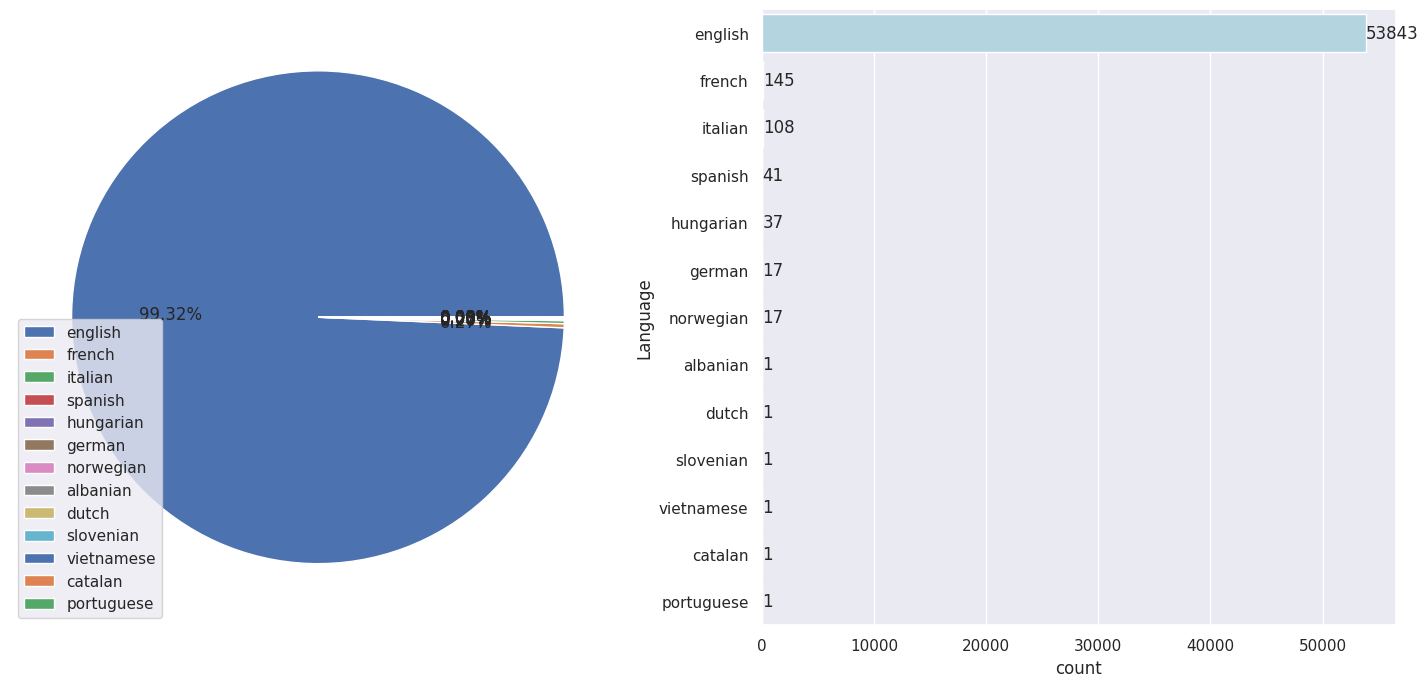

In [ ]:
fig,axs = plt.subplots(1,2)
axs[0].pie(train.Language.value_counts().values.tolist(),autopct='%.2f%%')
axs[0].legend(labels=train.Language.value_counts().index.tolist(),loc='lower left')
sns.countplot(data=train,y='Language',order=train.Language.value_counts().index.tolist(),ax=axs[1],color='lightblue')
axs[1].bar_label(axs[1].containers[0])
fig.show()

In [ ]:
#Descriptions included HTTP links

train.loc[train['Description'].str.contains(r'http\S+')].shape[0]

9

In [ ]:
train.loc[train['Description'].str.contains(r'http\S+')].head()['Description'].iloc[1]

" There's more to the story of the Clintons and 9/11. Over two nights -- September 10-11, 2006, just four months before Hillary announced the exploratory committee for her original presidential campaign, ABC aired The Path to 9/11, a riveting and factual docudrama. This acclaimed and balanced movie faulted two administrations -- Bill Clinton and George W. Bush. But fairness was not what Hillary wanted. Screenwriter Cyrus Nowrasteh told me he had expected the customary DVD distribution. But the Clintons, fearing the impact of DVD release during her campaign, successfully pressured Disney, which owns ABC, to bury the movie. This is a portion of a news article that originally appeared: http://www.frontpagemag.com/fpm/261541/hillarys-path-back-911-arnold-steinberg This article originally appeared in The Huffington Post http://www.huffingtonpost.com/arnold-steinberg/hillarys-path-back-to-911_b_9039658.html This article was written by Arnold Steinberg from Huffington Post and was legally lic

In [ ]:
def clean_text(text):

    # Remove strange pattern in different languages if exist

    text = re.sub('Mail <svaradi@sprynet.com> for translation. ','',text)

    # Remove twitter handles

    text = re.sub(r'@\S+', '', text)

    # Remove URLs

    text = re.sub(r'http\S+', '', text)

    # Remove punctuations

    text = re.sub(f'[{string.punctuation}]','',text)

    # Remove numbers

    text = re.sub(f'[{string.digits}]','',text)

    # Remove single charachters

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    return text

In [ ]:
#Clean Descriptions

train['Description'] = train['Description'].apply(clean_text)
test['Description'] = test['Description'].apply(clean_text)

In [ ]:
train[~train.Language.isin(['english'])]

,Title,Genre,Description,Language
210,Divorzio alla siciliana (1963),comedy,Il barone Fifě ha bisogno di un erede per ave...,italian
242,Túlvilági beszélö (1992),documentary,Tollas Tibor az os fordulatot kovetoen katona...,hungarian
282,"""Boogie-woogie 47"" (1980)",drama,En plusieurs familles de Montréal passent lé...,french
678,Pallati 176 (1986),comedy,English comedy by wellknown Albanian theater ...,albanian
806,Iszony (1965),drama,Mail to author for translation Karasz Nelli a...,hungarian
...,...,...,...,...
53697,Fantasmi e ladri (1959),comedy,Annunziata ha letto diecimila gialli spopola ...,italian
53712,Due notti con Cleopatra (1954),comedy,Cleopatra č una donna bellissima ma ha un pic...,italian
53878,Gyilkos kedv (1997),drama,Kora delutan egy iskolabol hazatero kislany c...,hungarian
54165,Az áldozat (1994),documentary,Mail author for translation Az os forradalom ...,hungarian


In [ ]:
#Translate other languages

def trans(text):
    try:
        return Translator().translate(text,dest='en').text
    except:
        return text
train.loc[~train['Language'].isin(['english']), 'Description']=train.loc[~train['Language'].isin(['english']),'Description'].apply(trans)
test.loc[~test['Language'].isin(['english']), 'Description']=test.loc[~test['Language'].isin(['english']),'Description'].apply(trans)

In [ ]:
train.drop(columns='Language',inplace=True)
test.drop(columns='Language',inplace=True)

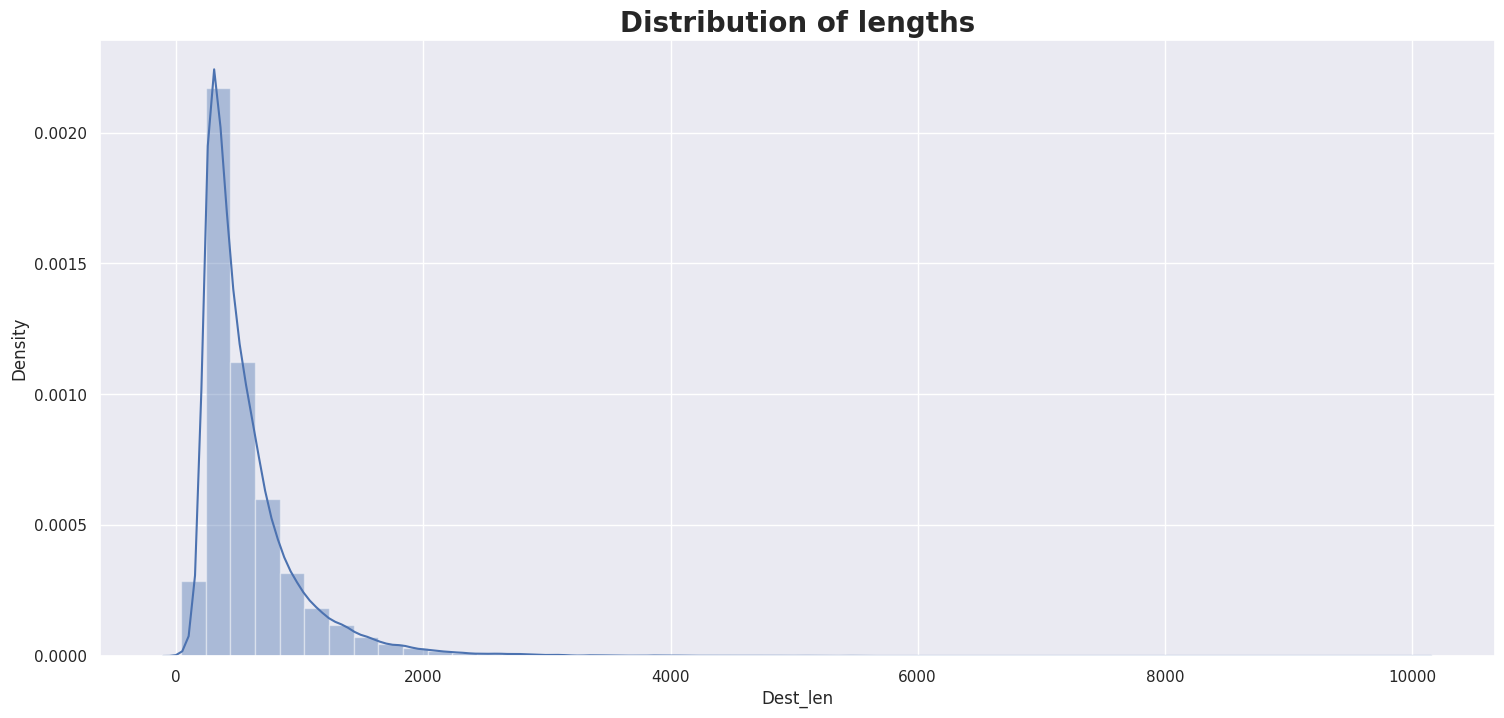

In [ ]:
#Distribution of text lengths

train['Dest_len'] = train['Description'].apply(len)
sns.distplot(train['Dest_len'])
plt.title('Distribution of lengths',fontweight='bold',fontsize=20)
plt.show()

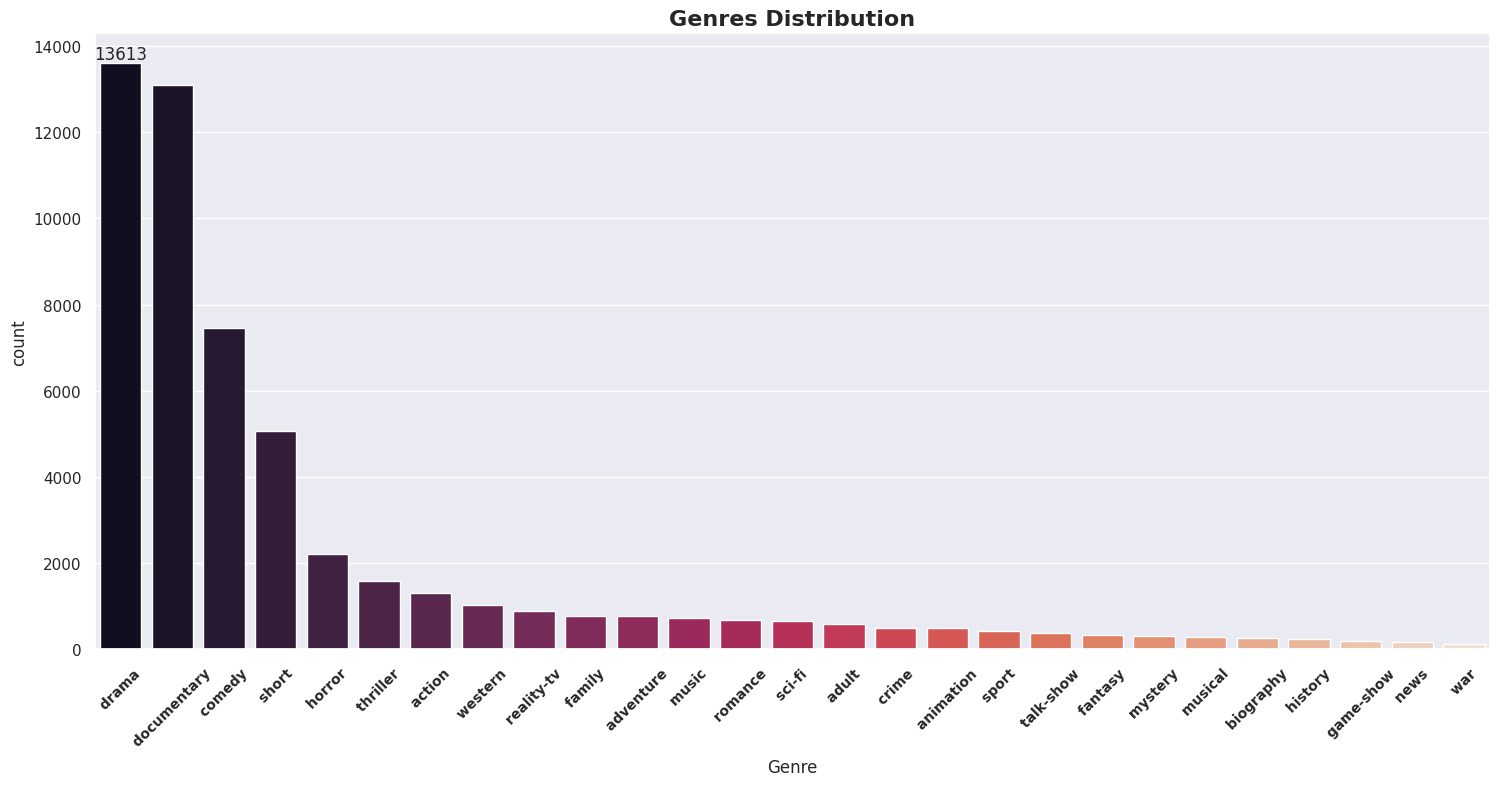

In [ ]:
ax=sns.countplot(data=train,x='Genre',order=train.Genre.value_counts().index,palette='rocket')
ax.bar_label(ax.containers[0])
plt.title('Genres Distribution',fontweight='bold',fontsize=16)
plt.xticks(rotation=45,fontweight='bold',fontsize=10)
plt.show()

In [ ]:
# Using TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,1), stop_words='english', min_df=2)
x_train = tfidf_vectorizer.fit_transform(train['Description'])
x_test = tfidf_vectorizer.transform(test['Description'])


In [ ]:
#We conclude before that drama and documentary have the majority of our data,
#so to avoid imbalance data in our model we will make randomoversampling
#Notice that the accuracy before sampling will be < the accuracy after oversampling

sampler = RandomOverSampler()

#We will pass to it the output of TfidfVectorizer from train data

x_train_resampled , y_train_resampled = sampler.fit_resample(x_train,train['Genre'])

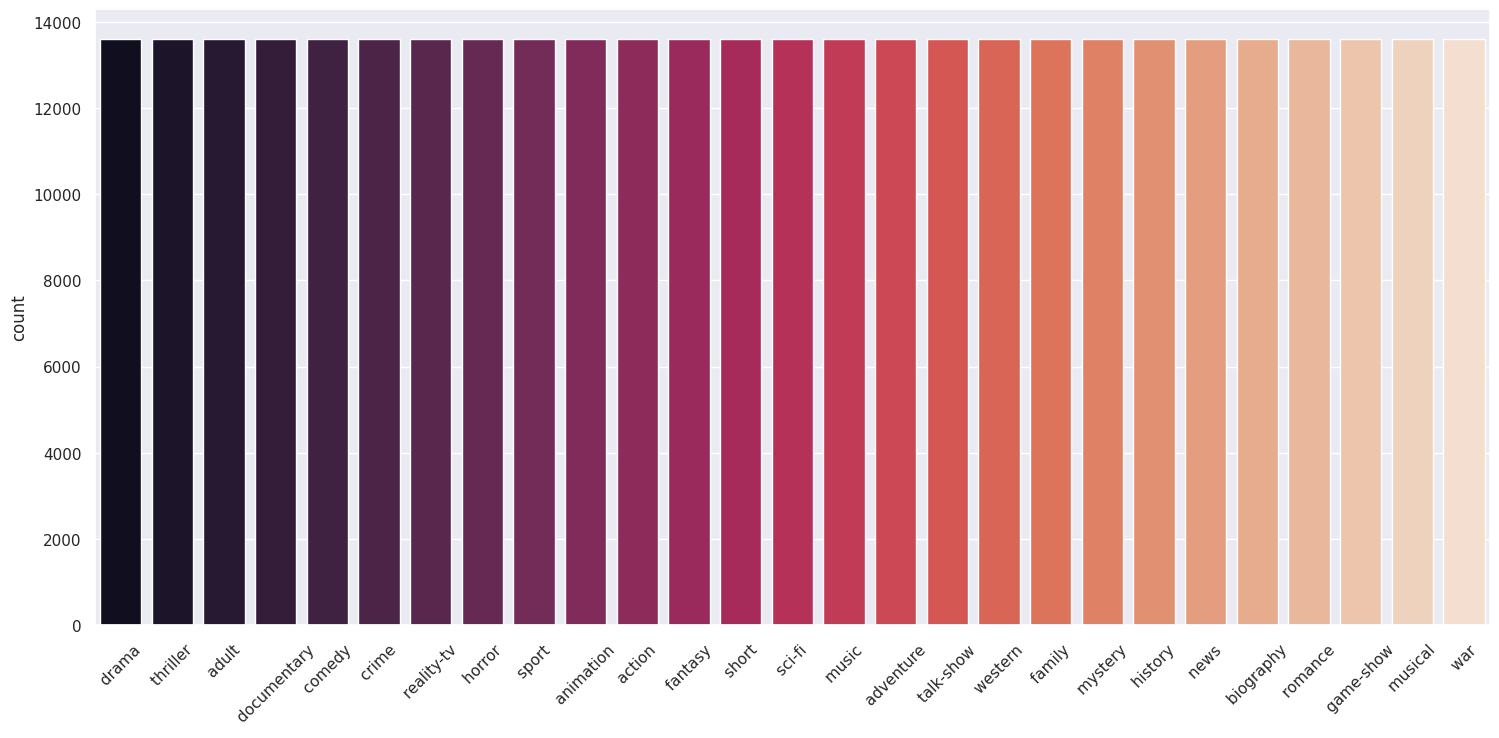

In [ ]:
#Let's take a look on genre distribution

sns.countplot(x=y_train_resampled.values,palette='rocket')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Double check for length of our data
print('Train :',x_train_resampled.shape[0])
print('Test :',y_train_resampled.shape[0])

Train : 367551
Test : 367551


In [ ]:
#Get the actual solutions to compare it with our predictions
y_actual = pd.read_csv(r"/content/drive/MyDrive/test_data_solution.txt",sep=':::',usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_actual.head()

,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [ ]:
#Naive Bayes Model
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train_resampled,y_train_resampled)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.5443173431734317
Running Time :  1.7 Secounds


In [ ]:
print(classification_report(y_actual,y_pred))

               precision    recall  f1-score   support

      action        0.36      0.48      0.41      1314
       adult        0.50      0.52      0.51       590
   adventure        0.32      0.25      0.28       775
   animation        0.31      0.23      0.27       498
   biography        0.04      0.03      0.03       264
      comedy        0.57      0.53      0.55      7446
       crime        0.16      0.17      0.16       505
 documentary        0.72      0.72      0.72     13096
       drama        0.64      0.57      0.60     13612
      family        0.27      0.23      0.25       783
     fantasy        0.18      0.15      0.16       322
   game-show        0.79      0.67      0.73       193
     history        0.09      0.06      0.07       243
      horror        0.52      0.68      0.59      2204
       music        0.40      0.72      0.51       731
     musical        0.19      0.10      0.13       276
     mystery        0.15      0.08      0.11       318
        n

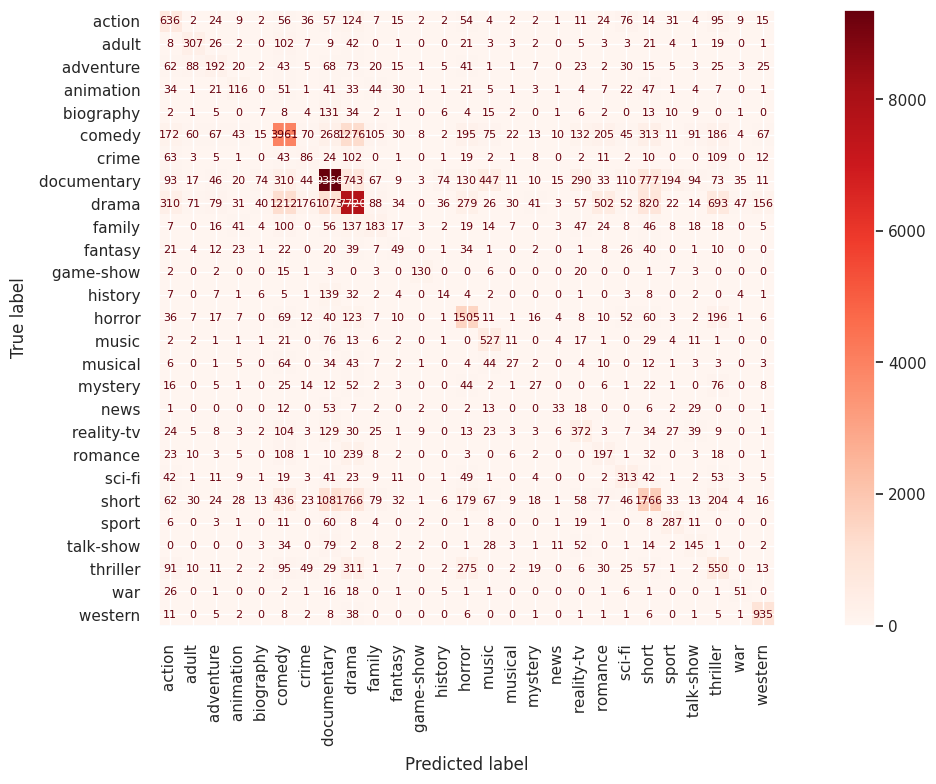

In [ ]:
cm =confusion_matrix(y_actual,y_pred,labels=NB.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NB.classes_)
cmd.plot(cmap=plt.cm.Reds,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [ ]:
pd.concat([pd.concat([test,y_actual],axis=1),pd.Series(y_pred)],axis=1).rename(columns={0:'Predicted_Genre'}).head(10)

,Title,Description,Actual_Genre,Predicted_Genre
0,Edgar's Lunch (1998),LR Brane loves his life his car his apartmen...,thriller,comedy
1,La guerra de papá (1977),Spain March Quico is very naughty child of t...,comedy,drama
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary
3,Meu Amigo Hindu (2015),His father has died he hasnt spoken with his ...,drama,drama
4,Er nu zhai (1955),Before he was known internationally as martia...,drama,action
5,Riddle Room (2016),Emily Burns is being held captive in room wit...,horror,thriller
6,L'amica (1969),The beautiful but neglected wife of brilliant...,drama,drama
7,Ina Mina Dika (1989),Vasu Inamdar Ina suffers from disorder where ...,comedy,comedy
8,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary
9,Press (2011),Press is story of young people overwhelmed by...,drama,short


In [ ]:
#We got low accuracy due to insufficient data for other categories
#So the model trained alot about drama and documentary movies so it's hard to discover the others
#Now let's try another approach and see the effect on data
y_train_modified = train['Genre'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')
y_actual_modified = y_actual['Actual_Genre'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')

In [ ]:
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train,y_train_modified)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual_modified,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.6947416974169742
Running Time :  0.2 Secounds
